# LSD profiles

This notebook contains exercises to understand the concept of LSD profiles

## 0. Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import astropy.units as u

## 1. Simple toy code to illustrate the concept of an observed spectrum being a convolution of a line mask and a profile shape

The LSD method relies on the approximation that the shape of spectral lines all have similar shapes, that are scaled by a factor called the *weigth* (a depth for intensity line profiles, and depth x wavelength x lande factor for Stokes V)

In this case, we can therefore think of a star's spectrum as being the convolution of a *mask* $M$ function with delta diracs at the position of each spectral lines (with a value corresponding the weigth of the spectral lines) and a profile shape $Z$ (the LSD profile).

In the first activity below, we illustrate this convolution process. We use a simple triangular shape for the $Z$ profile. The mask function is 25 units long, and has a delta dirac at positions 1, 6, and 16. 

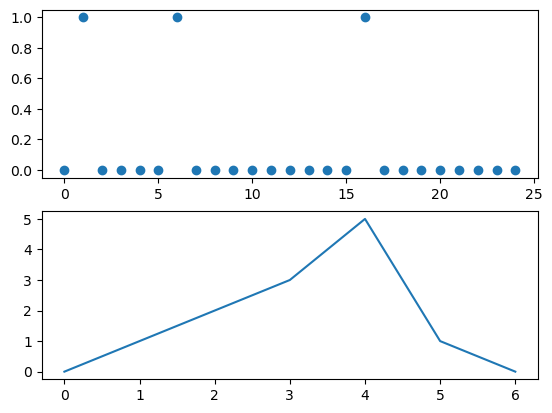

In [70]:
Z = np.array([0, 1, 2, 3, 5, 1, 0])
lines = [1, 6, 16]
nM = 25
M = np.zeros(nM)
M[lines]=1

fig, ax = plt.subplots(2,1)
ax[0].scatter(np.arange(0,M.size,1),M)
ax[1].plot(Z)

a. In the cell below, create your own function to calculate a convolution

In [54]:
def my_convol(M,Z):
    '''
    M: array to convolve
    Z: kernel array (NEED to have a odd number of elements)
    Note: this simple convolution will handle the boundaries
        by padding M with zeros. 
    '''

    nZ = Z.size # size of the z array
    # calculate by how much to shift the
    # kernel to be centered 
    # ONLY works for odd kernels
    shift = int(round(nZ/2))
    # size of the M array
    nM = M.size
    
    # pad the M array with nZ zeros on each end
    # to not have to make an exception 
    # for the edges
    pad = np.zeros((nZ))
    newM = np.append(pad,M)
    newM = np.append(newM,pad)

    # create an empty array for the results
    V = np.zeros(newM.size)

    for n in range(nZ+1,nZ+nM+1):
        # only calculating in the non-padded region

        # slicing the newM array to get the portion
        # that is involved for the calculation of V[n]
        slice_M = newM[n-shift:n+shift-1]
        # make the multiplication and sum
        V[n] = np.sum(slice_M*Z)

    # when returning, removing the padding with zeros
    return(V[nZ+1:nZ+nM+1])


b. Now in the cell below, calculate and graph the convolution between $M$ and $Z$

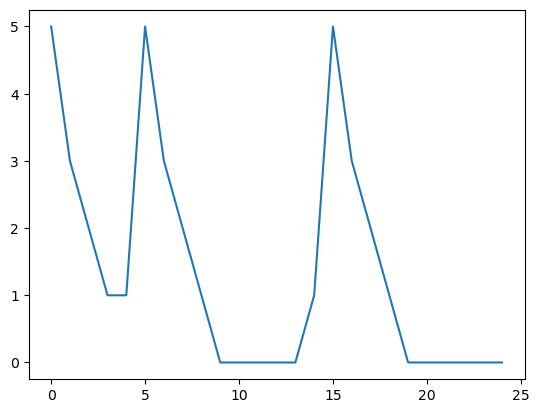

In [56]:
V = my_convol(M,Z)

fig, ax = plt.subplots(1,1)
ax.plot(V)

## 2. Matrix version of a convolution

We can also write a convolution as being the dot product between a matrix representation of the mask and the profile shape

a. In the cell below, you can see that I have already created an empty matrix for the Mask array (`M_mat`). Now fill in the associated diagonals with ones. Print you matrix to make sure it is correct

Hint: As we saw in class, we can use a padded version of the `M` array to create a loop that assigns a slice of this array shifted according to the loop index. 

[[0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


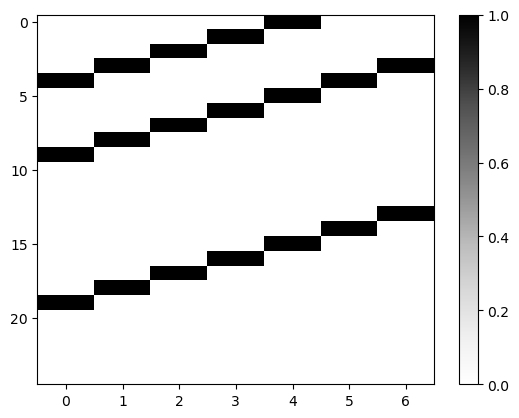

In [57]:
Z = np.array([0, 1, 2, 3, 5, 1, 0])
lines = [1, 6, 16]
nM = 25
M = np.zeros(nM)
M[lines]=1

# create a matrix filled with zeros for M
M_mat = np.zeros((nM, Z.size))

### solution ###

# padding the M array with zeros
pad = np.zeros((3))
newM = np.append(pad,M)
newM = np.append(newM,pad)
for j in range(0,Z.size):
    M_mat[:,j]=newM[0+j:25+j]

print(M_mat)

fig, ax = plt.subplots(1,1)
im = ax.imshow(M_mat, interpolation='none', aspect='auto', cmap='Greys', vmin=0.0, vmax=1.0)
plt.colorbar(im)

b. Now let's make the convolution by taking the dot product of $\bar{M}$ and $\vec{Z}$. Make a graph of the result

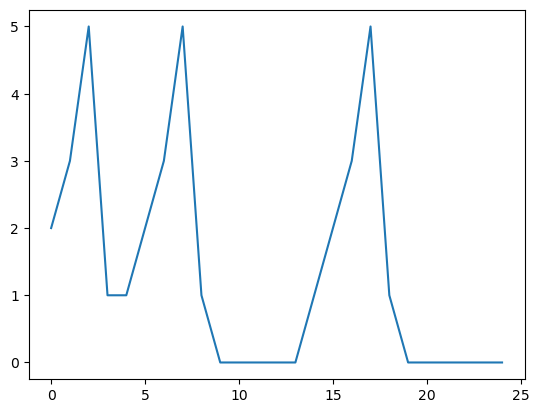

In [58]:
V = np.dot(M_mat, Z[::-1])

fig, ax = plt.subplots(1,1)
ax.plot(V)

## 3. Inversion of the simple toy model

In the previous section, we have seen that $\vec{V}=\bar{M}\cdot\vec{Z}$. We can now 'invert' this problem, aka find the least square fit to this system of equation. 

$$\vec{Z}_\mathrm{min} = (\bar{M}^T\bar{M})^{-1} \bar{M}^T\vec{V}$$

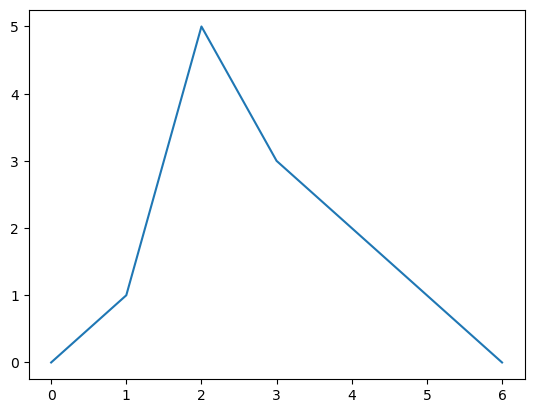

In [59]:
auto = np.dot(M_mat.T, M_mat)
cross = np.dot(M_mat.T,V)
LSD = np.dot(np.linalg.inv(auto), cross)

# There is a function as well in numpy.linalg that can do that for you. 
#LSD = np.linalg.lstsq(M_mat, V)
#LSD = LSD[0]


fig, ax = plt.subplots(1,1)
ax.plot(LSD)

b. Just for fun, let's check what this would look like if we were to add some noise to the data array

/var/folders/b0/wx58lg256fd4p48kl1w5l1zw0000gp/T/ipykernel_17726/4216255859.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  LSD = np.linalg.lstsq(M_mat, noisyV)


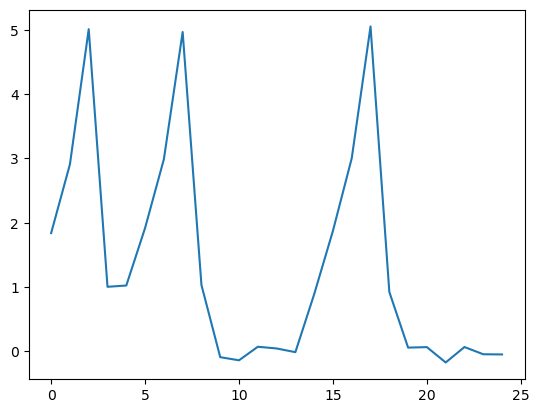

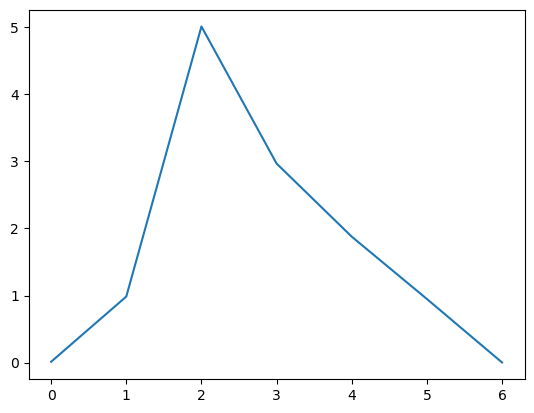

In [60]:
noisyV = V+np.random.normal(0,1/10, V.size)

fig, ax = plt.subplots(1,1)
ax.plot(noisyV)

LSD = np.linalg.lstsq(M_mat, noisyV)


fig, ax = plt.subplots(1,1)
ax.plot(LSD[0])

## 4. A more realistic example

Let look at a case where the observed spectrum has been measured with an even spacing in wavelength. 

For example, let's say that this spacing is an even 0.003 nm. 

If you have a spectral line that has a broadening of 100 km/s, what will be (i) width of the line profile in nm and (ii) the number of data points inside the line profile if the spectral line is located at
a) 300 nm
b) 800 nm

Use astropy units and constant packages. 

> Solution:
>
> $\frac{v}{c} = \frac{\lambda-\lambda_o}{\lambda_o}$
>
> $\lambda-\lambda_o = \frac{v}{c} \lambda_o$

In [71]:
spectra_dispersion = 0.003*u.nm


## Solution

delta_v = 100*u.km/u.s

# a)
lambda0 = 300*u.nm
delta_lambda = 2*(delta_v / const.c * lambda0).to(u.nm)
npoints = 2*delta_lambda/spectra_dispersion
print('for 300nm, the line is {} broad and has {} data points'.format(delta_lambda, npoints))

# b)
lambda0 = 800*u.nm
delta_lambda = 2*(delta_v / const.c * lambda0).to(u.nm)
npoints = 2*delta_lambda/spectra_dispersion
print('for 800nm, the line is {} broad and has {} data points'.format(delta_lambda, npoints))


for 300nm, the line is 0.20013845711889125 nm broad and has 133.42563807926084 data points
for 800nm, the line is 0.5337025523170433 nm broad and has 355.80170154469556 data points


As you can see from the exercise above, we have a mismatch in units and dispersion (i.e. grid spacing) between the observed spectrum $\vec{V}$ and the mask $\vec{M}$.

In the cell below, I created for you a fake observation with 4 spectral lines. The broadening of each line is 20 km/s, and I use a Gaussian line profile, for simplicity.

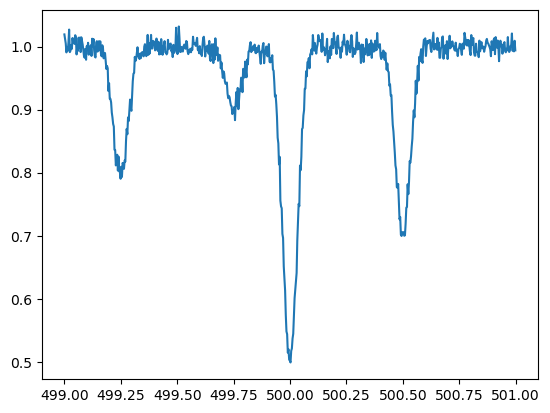

In [62]:
delta_v = 2.0 * u.km/u.s # desired dispersion for the LSD profile (typical value for good resolution data)
delta_lambda = 0.003 * u.nm # grid spacing of the observed spectrum (similar to espadons)
vbroad = 20 * u.km/u.s # broadened width of spectral lines

# create an array of wavelenght for the observation
wave = np.arange(499, 501, delta_lambda.value)*u.nm

# add a spectral line
lambda0 = 500 * u.nm # line
lambda1 = 499.25 * u.nm
lambda2 = 499.75 * u.nm
lambda3 = 500.5 * u.nm # line

flux = 1.0- (
        0.5*np.exp((-0.5*(wave-lambda0)**2/(vbroad/const.c*lambda0)**2).decompose())
        + 0.2*np.exp((-0.5*(wave-lambda1)**2/(vbroad/const.c*lambda1)**2).decompose())
        + 0.1*np.exp((-0.5*(wave-lambda2)**2/(vbroad/const.c*lambda2)**2).decompose()) 
        + 0.3*np.exp((-0.5*(wave-lambda3)**2/(vbroad/const.c*lambda3)**2).decompose()) 
        )

# add a bit of noise
snr = 100
sigma = 1/snr
flux = flux + np.random.normal(0, sigma, flux.size)

# plot the fake spectrum
fig, ax = plt.subplots(1,1)
ax.plot(wave, flux)

Now, we need to construct the $\bar{M}$ 

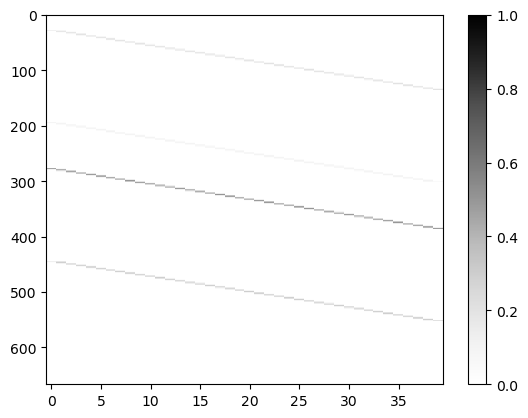

In [63]:
vel_Z = 5 * u.km/u.s
vel = np.arange(-100,100,vel_Z.value) * u.km/u.s

M = np.zeros((wave.size, vel.size))

lines = [lambda0, lambda1, lambda2, lambda3]
wline = [0.5, 0.2, 0.1, 0.3]


# Solution:

# A) Make a loop on lines first
for i in range(0,len(lines)):
    # calculate vi
    vi = (const.c*(wave-lines[i])/lines[i]).to(u.km/u.s)
    # B) Make a loop on the velocity points in Z
    for j in range(0,vel.size-1):
        # the current LSD profile velocity point is:
        vj = vel[j]
        vjp1 = vel[j+1]
        # check where the current LSD profile velocity matches
        # the vi array
        n = np.where(np.logical_and(vi >= vj, vi<=vjp1))
        # C) Make a loop over all the row in M that matches the criterion
        for k in n[0]:
            M[k,j]=M[k,j] + wline[i]*(vjp1 - vi[k])/(vjp1-vj)
            M[k,j+1]=M[k,j+1] + wline[i]*(vi[k]-vj)/(vjp1-vj)



######
fig, ax = plt.subplots(1,1)
im = ax.imshow(M, interpolation='none', aspect='auto', cmap='Greys', vmin=0.0, vmax=1.0)
plt.colorbar(im)

Now that we have $\bar{M}$, we can calculate the LSD profile. 

The solution of this least-square problem is:

$$\vec{Z} =  (\bar{M}^T \bar{S}^2 \bar{M})^{-1} (\bar{M}^T \bar{S}^2 \vec{V}), $$

where $\bar{S}$ is a diagonal matrix with the error bars for each datapoint in the spectrum (already defined in the code below -- just using a constant error bar for the whole fake spectrum)

The first term is the inverse of an auto-correlation matrix, and the second term is a cross-correlation.

In the cell below, calculate $\vec{Z}$ and make a graph

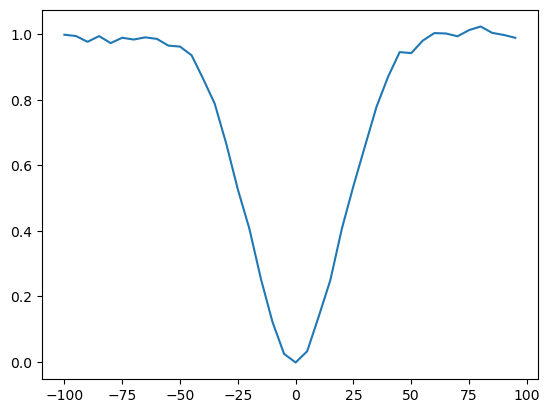

In [68]:
S = np.zeros((wave.size,wave.size))
np.fill_diagonal(S,sigma)

auto_correlation = np.dot(np.dot(M.T, S**2), M)
cross_correlation = np.dot(np.dot(M.T, S**2), 1.0-flux)

Z = np.dot( np.linalg.inv(auto_correlation), cross_correlation )

fig, ax = plt.subplots(1,1)
ax.plot(vel, 1.0-Z)

Now that we have our LSD profile, we can reconstruct what the predicted spectrum would look like by simply taking the dot product between Z and the mask matrix. 

In the cell below, the fake spectrum is already plotted. Calculate the model spectrum predicted by LSD and overplot

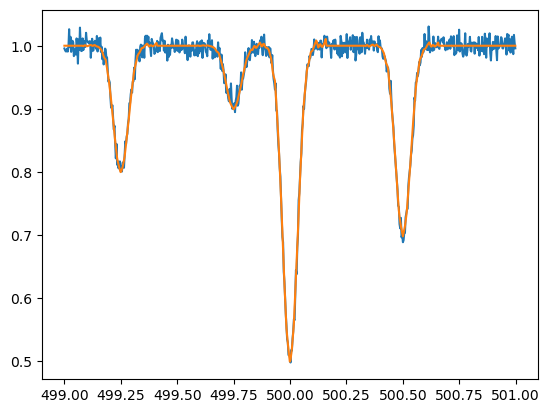

In [28]:
fig, ax = plt.subplots(1,1)
ax.plot(wave, flux)

# Solution

model = np.dot(M, Z)
ax.plot(wave, 1-model)


## Double mask

(667, 80)
(667, 160)
(160,)


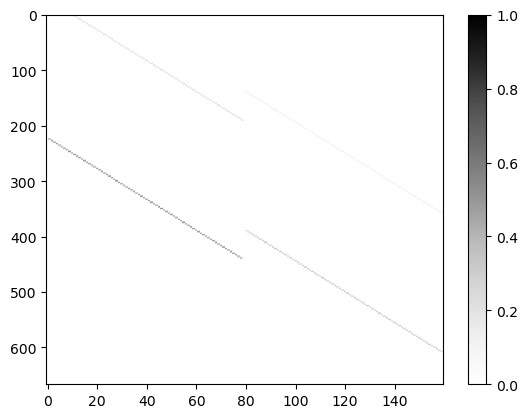

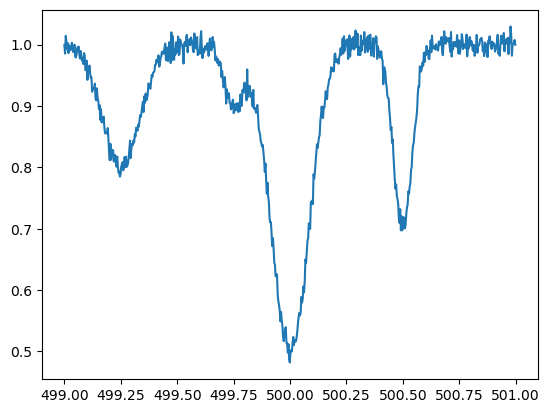

In [32]:
# Solution from the previous exercise in function format, 
# for convinience. 
def get_M(wave, vel, lines, wline):

    M = np.zeros((wave.size, vel.size))
    # A) Make a loop on lines first
    for i in range(0,len(lines)):
        # calculate vi
        vi = (const.c*(wave-lines[i])/lines[i]).to(u.km/u.s)
        # B) Make a loop on the velocity points in Z
        for j in range(0,vel.size-1):
            # the current LSD profile velocity point is:
            vj = vel[j]
            vjp1 = vel[j+1]
            # check where the current LSD profile velocity matches
            # the vi array
            n = np.where(np.logical_and(vi >= vj, vi<=vjp1))
            # C) Make a loop over all the row in M that matches the criterion
            for k in n[0]:
                M[k,j]=M[k,j] + wline[i]*(vjp1 - vi[k])/(vjp1-vj)
                M[k,j+1]=M[k,j+1] + wline[i]*(vi[k]-vj)/(vjp1-vj)
    
    return(M)

lambda0 = 500 * u.nm # line
lambda1 = 499.25 * u.nm
lambda2 = 499.75 * u.nm
lambda3 = 500.5 * u.nm # line
lines = [lambda0, lambda1, lambda2, lambda3]
wline = [0.5, 0.2, 0.1, 0.3]

delta_lambda = 0.003 * u.nm # grid spacing of the observed spectrum (similar to espadons)
# create an array of wavelenght for the observation
wave = np.arange(499, 501, delta_lambda.value)*u.nm

vel_Z = 5 * u.km/u.s
vel = np.arange(-200,200,vel_Z.value) * u.km/u.s

vbroad1 = 50 * u.km/u.s # broadened width of spectral lines
Z1 = np.exp((-0.5*vel**2/vbroad1**2).decompose())

vbroad2 = 25 * u.km/u.s # broadened width of spectral lines
Z2 = np.exp((-0.5*vel**2/vbroad2**2).decompose())

lines1 = lines[0:2]
wline1 = wline[0:2]

lines2 = lines[2:4]
wline2 = wline[2:4]

M1 = get_M(wave, vel, lines1, wline1)
M2 = get_M(wave, vel, lines2, wline2)
print(M1.shape)

M = np.hstack((M1, M2))
print(M.shape)

Z = np.hstack((Z1,Z2))
print(Z.shape)

flux = 1 - np.dot(M, Z)

# add a bit of noise
snr = 100
sigma = 1/snr
flux = flux + np.random.normal(0, sigma, flux.size)
S = np.zeros((wave.size,wave.size))
np.fill_diagonal(S,sigma)

######
fig, ax = plt.subplots(1,1)
im = ax.imshow(M, interpolation='none', aspect='auto', cmap='Greys', vmin=0.0, vmax=1.0)
plt.colorbar(im)

fix, ax = plt.subplots(1,1)
ax.plot(wave, flux)

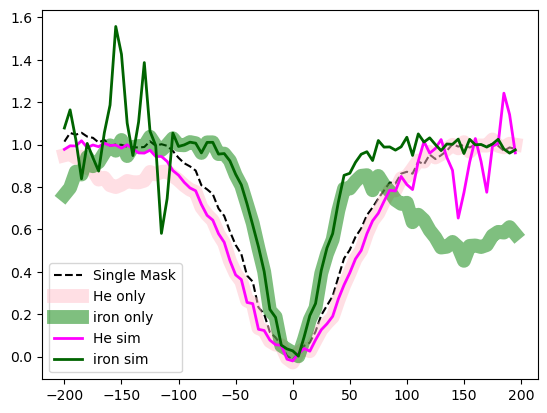

In [33]:
def get_Z(M, S, flux):
    auto_correlation = np.dot(np.dot(M.T, S**2), M)
    cross_correlation = np.dot(np.dot(M.T, S**2), 1.0-flux)

    Z = np.dot( np.linalg.inv(auto_correlation), cross_correlation )
    return Z


Z_single = get_Z(M1+M2, S, flux)
Z1_single = get_Z(M1, S, flux)
Z2_single = get_Z(M2, S, flux)
Z = get_Z(M, S, flux)
Z1 = Z[:vel.size]
Z2 = Z[vel.size:]

fig, ax = plt.subplots(1,1)
ax.plot(vel, 1.0-Z_single, c='k', ls='--', label='Single Mask')
ax.plot(vel, 1.0-Z1_single, c='pink', lw=10, alpha=0.5, label='He only')
ax.plot(vel, 1.0-Z2_single, c='green', lw=10, alpha=0.5, label='iron only')
ax.plot(vel, 1.0-Z1, c='magenta', lw=2, label='He sim')
ax.plot(vel, 1.0-Z2, c='darkgreen', lw=2, label='iron sim')

ax.legend(loc=0)